In [1]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


%load_ext autoreload
%autoreload 2
from iqid import helper as iq
from iqid import spec

pltmap = iq.set_plot_parms()

C:\Users\Robin\anaconda3\envs\beq\lib\site-packages\h5py\__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


# Import and plot example spectrum

In [3]:
fname = os.path.join("data_sample", "3_Sample", "sample_ac225.csv")

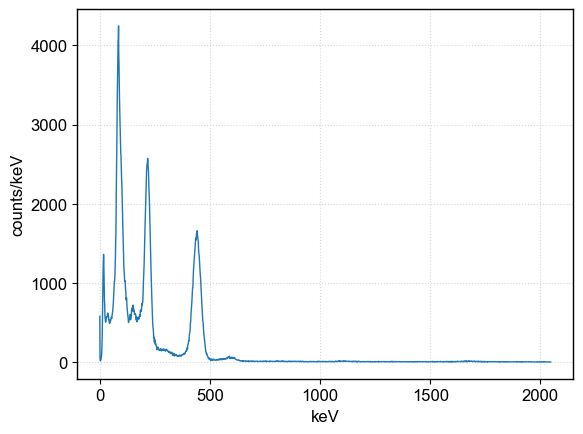

In [4]:
spectra = np.genfromtxt(fname, delimiter=',', skip_header=2)

spectrum = spectra[2:]
kev = np.arange(2048)
plt.plot(spectrum) # example spectrum
plt.xlabel('keV')
plt.ylabel('counts/keV')
plt.show()

# Demonstrate some plotting/fitting parts of the package

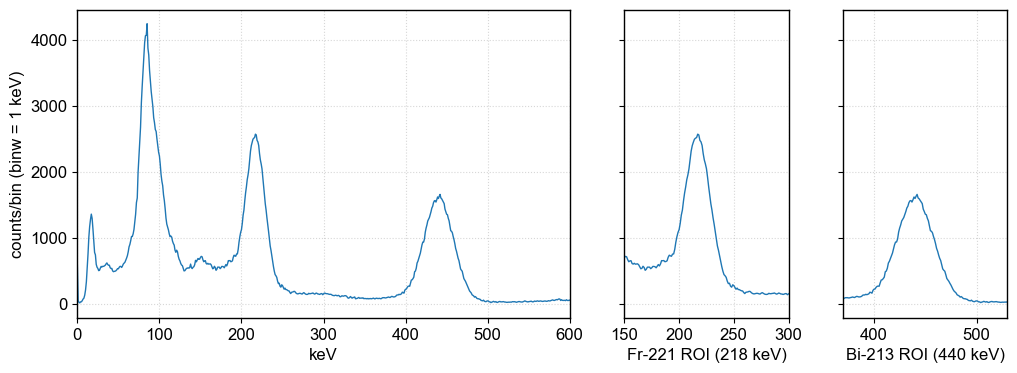

In [5]:
# manually defined some regions of interest (automatic peak detection methods exist)
ROIFr = np.array([175, 270]) 
ROIBi = np.array([385, 515])

# create energy spectrum object from the example spec we picked and plot with ROIs
espec = spec.energy_spectrum(kev, spectrum)
espec.init_plot()
plt.show()

### Use the module to try out (visualize) a set of initial fit parameters
- curve fitting can sometimes be finicky
- if your fit doesn't converge, it's often because your p0 wasn't close enough
- these are the two default values in my package

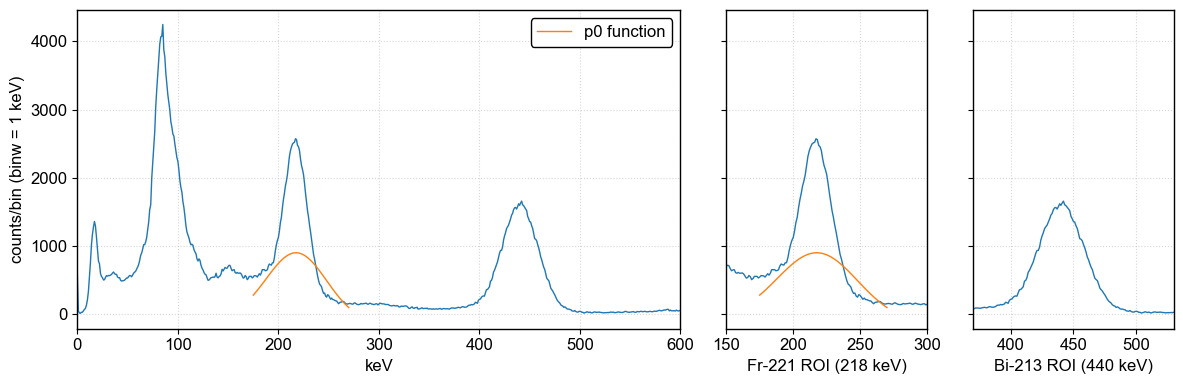

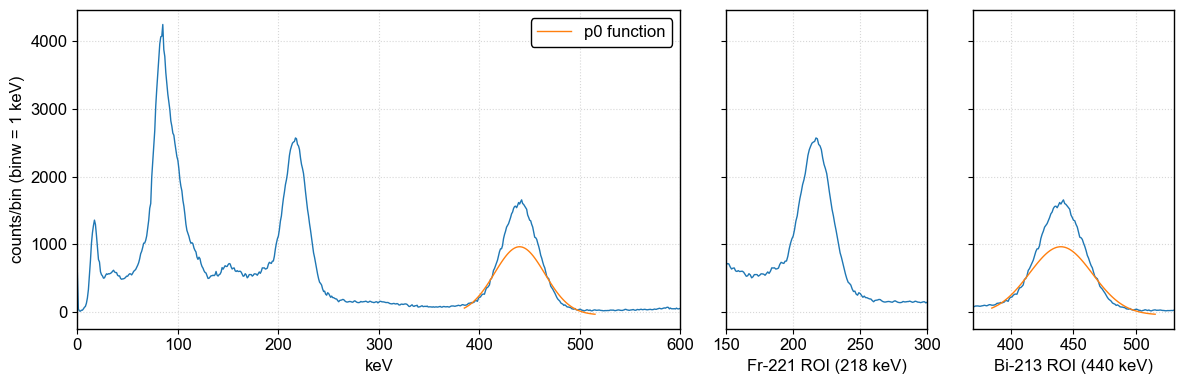

In [6]:
espec.test_p0([1000, 218, 30, -0.5, 10], ROIFr, 1)
espec.test_p0([1000, 440, 25, -0.1, 10], ROIBi, 2)

The initial p0 on the Fr-221 peak is pretty bad (see above). But, the fit still converges fine in this example. This probably wouldn't fly if you were doing a double Gaussian fit or something more complicated.

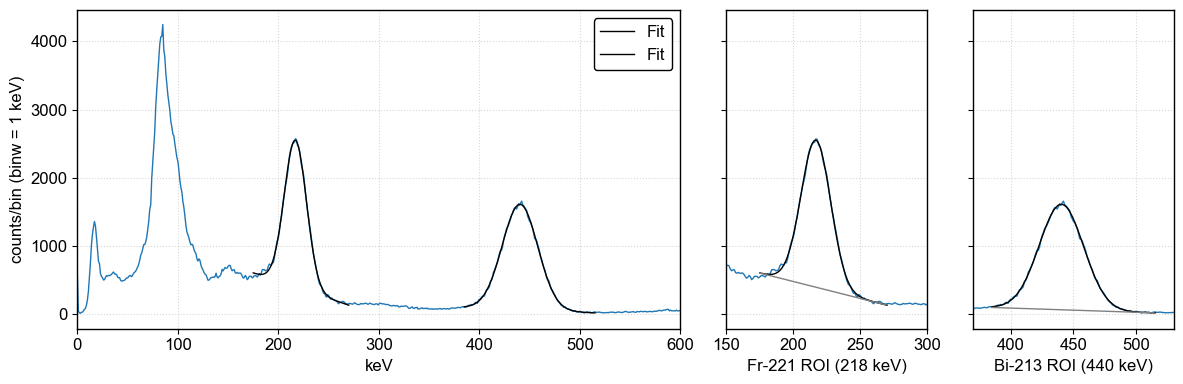

In [7]:
espec.init_plot()
espec.fit_gaussian(ROIFr, p0='fr', func=spec.gaussian)
espec.plot_fit(ROIFr, 1, func=spec.gaussian)

espec.fit_gaussian(ROIBi, p0='bi', func=spec.gaussian)
espec.plot_fit(ROIBi, 2, func=spec.gaussian)
plt.tight_layout()
plt.show()

# Use the fitted peaks to extract quantitative information

## Get counts in each peak

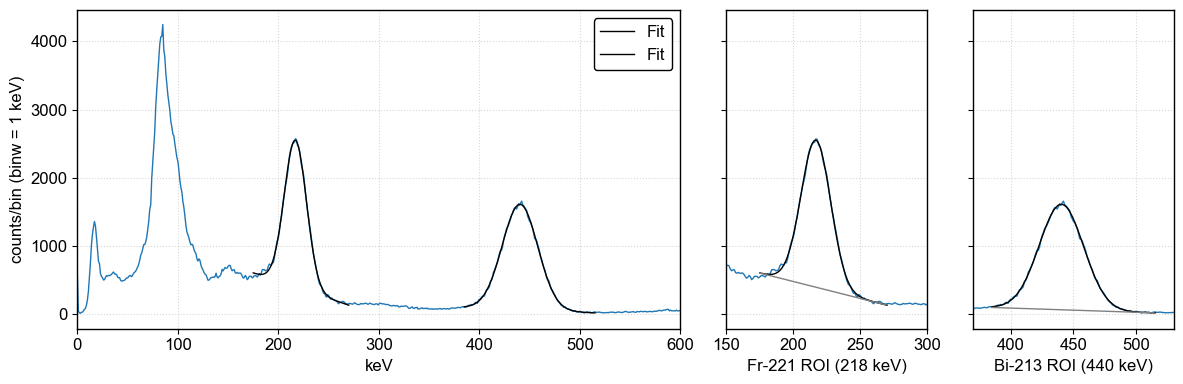

In [8]:
# fr_nets, dfr_nets, fr_gross, bi_nets, dbi_nets, bi_gross
fr, dfr, frg, bi, dbi, big = spec.ac225_spectra_stats(kev, spectrum, ROIFr, ROIBi, 
                                                      min_peak_signal=5, vis=True, unpack=True)   

In [9]:
print(fr, dfr, frg, bi, dbi, big)

60096.134909267625 397.72702616105653 95089.0 68463.23312739251 314.5651331893986 76235.0


## Efficiency calibration
- suppose we know that the quantity of Ac-225 in this spectrum is 0.5 µCi
- we want to know the detector efficiency at each energy

In [10]:
uCi = 0.5

fr_eff, bi_eff = spec.calibrate_ac225(kev, spectrum, ROIFr, ROIBi, uCi, t=60, vis=False)
print(fr_eff, bi_eff)

0.46672984552087315 0.236316430663051


### Sanity check: with the efficiency and branching ratio corrections, Fr/Bi should = 1 
**Note** This sample is a "standard", which means it's some Ac-225 for calibration purposes that is in secular equilibrium. Not all samples are guaranteed to be in equilibrium.

In [11]:
fr_br = 0.116 # intensity (br) of fr gamma ray
bi_br = 0.261 # " " of bi gamma ray

ratio, dratio = spec.get_activity_ratio(fr, dfr, bi, dbi, fr_eff, bi_eff)
print('Ratio: {:.3f} +/- {:0.3f}'.format(ratio, dratio)) # hooray!

Ratio: 1.000 +/- 0.008
